In [1]:
from re import A, S
import tensorflow as tf

import math
import pandas as pd

from tensorflow.python.ops.gen_control_flow_ops import no_op
from GAE.utils import gen_f0_from_tensors,FramsManager
from FramsticksLib import *
from scipy.spatial import distance
from scipy.stats import spearmanr
from enum import Enum
import spektral.data as data
from GAE.LossManager import LossManager
from GAE.GraphDataset import GraphDataset
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from GAE.utils import *
class LossTypes(Enum):
    joints = "joints"
    parts = "parts"
    fitness = "fitness"
    dissim = "dissim"
    No = "None"
    def __str__(self):
        return self.name


In [4]:
pathframs = "/home/adam/Framsticks/Framsticks50rc19"
path_sim ="/home/adam/thesis/VGAE/framspy/eval-allcriteria_new.sim"
pathdata ="/home/adam/thesis/VGAE/framspy/graphs/gen2/"


In [5]:
fm = FramsManager(pathframs)

Using Framsticks version: 5.0
Home (writable) dir     : /home/adam/Framsticks/Framsticks50rc19/data
Resources dir           : /home/adam/Framsticks/Framsticks50rc19/data



In [13]:
train, test = GraphDataset(pathframs, pathdata,fitness=None,size_of_adj=15,train_size=0.8,max_examples = 9999999).read()


Using Framsticks version: 5.0
Home (writable) dir     : /home/adam/Framsticks/Framsticks50rc19/data
Resources dir           : /home/adam/Framsticks/Framsticks50rc19/data

Using Framsticks version: 5.0
Home (writable) dir     : /home/adam/Framsticks/Framsticks50rc19/data
Resources dir           : /home/adam/Framsticks/Framsticks50rc19/data

Available objects: ['CheckpointEvent', 'Collision', 'CrCollision', 'Creature', 'CreatureSettings', 'CreatureSignals', 'CreatureSnapshot', 'Dictionary', 'ExpProperties', 'ExpState', 'ExtValue', 'File', 'FunctionReference', 'GenMan', 'GenManStats', 'GenePool', 'GenePools', 'Geno', 'Genotype', 'Interface', 'Joint', 'Loader', 'Math', 'MechJoint', 'MechPart', 'MessageCatcher', 'Model', 'ModelGeometry', 'ModelSymmetry', 'Neuro', 'NeuroClass', 'NeuroClassLibrary', 'NeuroDef', 'NeuroSignals', 'NeuronsSimEnabled', 'ODE', 'Orient', 'Part', 'Population', 'Populations', 'Ref', 'Signal', 'SignalView', 'SimilMeasure', 'SimilMeasureDistribution', 'SimilMeasureGreed

In [14]:
train

GraphData(n_graphs=29283)

In [15]:
test

GraphData(n_graphs=7321)

lossManager = LossManager(pathframs,path_sim,"vertpos")

In [9]:
lossManager = LossManager(pathframs,path_sim,"vertpos")

Using Framsticks version: 5.0rc19.1
Home (writable) dir     : /home/adam/Framsticks/Framsticks50rc19/data
Resources dir           : /home/adam/Framsticks/Framsticks50rc19/data

Using Framsticks version: 5.0rc19.1
Home (writable) dir     : /home/adam/Framsticks/Framsticks50rc19/data
Resources dir           : /home/adam/Framsticks/Framsticks50rc19/data

Available objects: ['CheckpointEvent', 'Collision', 'CrCollision', 'Creature', 'CreatureSettings', 'CreatureSignals', 'CreatureSnapshot', 'Dictionary', 'ExpProperties', 'ExpState', 'ExtValue', 'File', 'FunctionReference', 'GenMan', 'GenManStats', 'GenePool', 'GenePools', 'Geno', 'Genotype', 'Interface', 'Joint', 'Loader', 'Math', 'MechJoint', 'MechPart', 'MessageCatcher', 'Model', 'ModelGeometry', 'ModelSymmetry', 'Neuro', 'NeuroClass', 'NeuroClassLibrary', 'NeuroDef', 'NeuroSignals', 'NeuronsSimEnabled', 'ODE', 'Orient', 'Part', 'Population', 'Populations', 'Ref', 'Signal', 'SignalView', 'SimilMeasure', 'SimilMeasureDistribution', 'Simil

In [17]:
a = "123"
b = "123"

In [18]:
if hash(a) == hash(b):
    print("equall")

equall


In [21]:
hash(train[0].a)

TypeError: unhashable type: 'numpy.ndarray'

In [16]:
end = False
c = 500

# vertpos, number of parts, number of joints
columns = ["vertpos","n_parts","n_joints","gen"]
all_data= pd.DataFrame(columns=columns)

itTrain = math.ceil(len(train)/c)
itTest = math.ceil(len(test)/c)
# print(it)
# data_model = [[vertpos,n_parts,n_joints]]
# data_model = pd.DataFrame(data_model,columns=columns) 
for i in range(itTrain):
    data = train[i*c:(i+1)*c]
    a_arr = []
    x_arr = []
    for g in data:
        a_arr.append(g.a)
        x_arr.append(g.x)
#     print(data[0].a)
    d =[(tf.convert_to_tensor(x_arr)), tf.convert_to_tensor(a_arr)]
    x,a= d
#     print(x[0])
    gen_list = gen_f0_from_tensors(x,a)
#     print(gen_list[0])
    ev= lossManager.framsLib.evaluate(gen_list)
    temp_list = []
    for e in range(len(ev)):
        temp_list.append([ev[e]['evaluations']['']['vertpos'],ev[e]['evaluations']['']['numparts'],ev[e]['evaluations']['']['numjoints'],gen_list[e]])
#     print(ev[0]['evaluations'][''])
    part_data = pd.DataFrame(temp_list,columns=columns) 
    all_data = all_data.append(part_data, ignore_index=True)
    if i%10:
        print(i)

for i in range(itTest):
    data = test[i*c:(i+1)*c]
    a_arr = []
    x_arr = []
    for g in data:
        a_arr.append(g.a)
        x_arr.append(g.x)
    d =[(tf.convert_to_tensor(x_arr)), tf.convert_to_tensor(a_arr)]
    x,a= d
    gen_list = gen_f0_from_tensors(x,a)
    ev= lossManager.framsLib.evaluate(gen_list)
    temp_list = []
    for e in range(len(ev)):
        temp_list.append([ev[e]['evaluations']['']['vertpos'],ev[e]['evaluations']['']['numparts'],ev[e]['evaluations']['']['numjoints'],gen_list[e]])
#     print(ev[0]['evaluations'][''])
    part_data = pd.DataFrame(temp_list,columns=columns) 
    all_data = all_data.append(part_data, ignore_index=True)
    if i%10:
        print(i)
#     break


{'fit_stdev': 0.0, 'vertvel': 2.6580922852348366e-09, 'numjoints': 12, 'fit': 1.022643863928561e-08, 'lifespan': 5000.0, 'instances': 0, 'numparts': 13, 'numneurons': 0, 'time': 0.041281938552856445, 'vertpos': 0.922725485389894, 'velocity': 1.022643863928561e-08, 'distance': 5.113219319642805e-05, 'numconnections': 0}
{'fit_stdev': 0.0, 'vertvel': 9.81307553438171e-11, 'numjoints': 13, 'fit': 1.179536683958705e-09, 'lifespan': 5000.0, 'instances': 0, 'numparts': 10, 'numneurons': 0, 'time': 0.0352630615234375, 'vertpos': 2.174817016434008, 'velocity': 1.179536683958705e-09, 'distance': 5.8976834197935254e-06, 'numconnections': 0}
1
{'fit_stdev': 0.0, 'vertvel': 1.0472854169663038e-09, 'numjoints': 9, 'fit': 1.4133746526625155e-08, 'lifespan': 5000.0, 'instances': 0, 'numparts': 10, 'numneurons': 0, 'time': 0.038001060485839844, 'vertpos': 1.576690944778339, 'velocity': 1.4133746526625155e-08, 'distance': 7.066873263312578e-05, 'numconnections': 0}
2
{'fit_stdev': 0.0, 'vertvel': 1.529

In [17]:
ev

[{'num': 22408,
  'name': 'Ydimah Tihih',
  'evaluations': {'': {'fit_stdev': 0.0,
    'vertvel': 2.8580968036706625e-10,
    'numjoints': 13,
    'fit': 4.216482767960777e-10,
    'lifespan': 5000.0,
    'instances': 0,
    'numparts': 14,
    'numneurons': 0,
    'time': 0.05016899108886719,
    'vertpos': 0.42157256831477136,
    'velocity': 4.216482767960777e-10,
    'distance': 2.1082413839803884e-06,
    'numconnections': 0}}},
 {'num': 22409,
  'name': 'Yuun Didis',
  'evaluations': {'': {'fit_stdev': 0.0,
    'vertvel': 6.738002232831163e-11,
    'numjoints': 17,
    'fit': 8.15051633026803e-11,
    'lifespan': 5000.0,
    'instances': 0,
    'numparts': 13,
    'numneurons': 0,
    'time': 0.0454409122467041,
    'vertpos': 0.32579210872974673,
    'velocity': 8.15051633026803e-11,
    'distance': 4.0752581651340156e-07,
    'numconnections': 0}}},
 {'num': 22410,
  'name': 'Ilacu Dihih',
  'evaluations': {'': {'fit_stdev': 0.0,
    'vertvel': 2.6399163092882814e-09,
    'numj

In [23]:
all_data.loc[all_data['vertpos'] == max(all_data['vertpos'])].iloc[0]['gen']

'//0\np:2.298312727204787, 2.298312727204787, 2.298312727204787\np:1.0942442864477269, 3.8224330349472115, 2.298312727204787\np:0.7028104614021384, 4.270621270802676, 4.175778174543551\np:1.565672987248388, 3.759406037940308, 5.8569109926396425\np:1.4783265317666054, 4.289475890299355, 7.75219449408074\np:0.7772495399273303, 4.088782239960528, 9.58258642105356\np:4.29525112746713, 2.403939894437829, 2.298312727204787\np:1.391318972254275, 0.5160999449083605, 2.298312727204787\np:1.1953890754817635, 0.0, 4.190603268140904\np:1.3044577547232905, 0.0002276606071149878, 6.157922176447118\np:1.614924086010032, 0.32638985797429987, 8.017652350167477\np:1.7004047886718914, 0.7839183371053251, 9.930519748252479\nj:0, 1\nj:0, 6\nj:0, 7\nj:1, 2\nj:2, 3\nj:3, 4\nj:4, 5\nj:7, 8\nj:8, 9\nj:9, 10\nj:10, 11\n'

In [5]:
# all_data.to_csv('all_data_base.csv',index=None)
data_velocity = pd.read_csv("all_data_base.csv")
data_velocity.describe()

,vertpos,n_parts,n_joints
count,25039.000000,25039.000000,25039.000000
mean,0.046339,7.096450,7.699708
std,0.105291,3.554737,6.148264
min,-0.049551,2.000000,1.000000
25%,-0.015000,4.000000,3.000000
50%,0.002638,6.000000,5.000000
75%,0.066426,10.000000,11.000000
max,1.135704,15.000000,30.000000


In [6]:
# all_data.to_csv('plots/all_data_vertpos.csv',index=None)
data_vertpos = pd.read_csv("plots/all_data_vertpos.csv")
data_vertpos.describe()

,vertpos,n_parts,n_joints
count,10504.000000,10504.000000,10504.000000
mean,1.268434,10.096820,11.068926
std,0.821135,3.679957,6.260979
min,-0.010000,1.000000,0.000000
25%,0.485066,8.000000,7.000000
50%,1.353009,11.000000,10.000000
75%,2.070922,13.000000,14.000000
max,2.724392,15.000000,30.000000


In [21]:
data_vertpos.loc[data_vertpos["vertpos"]<0.5]

,vertpos,n_parts,n_joints
9,-0.010000,2,1
10,0.325792,13,17
14,0.489378,12,11
20,0.160388,3,2
24,0.246745,13,22
...,...,...,...
10483,0.106220,12,11
10484,0.291960,9,8
10488,0.106220,12,11
10495,0.302704,14,24


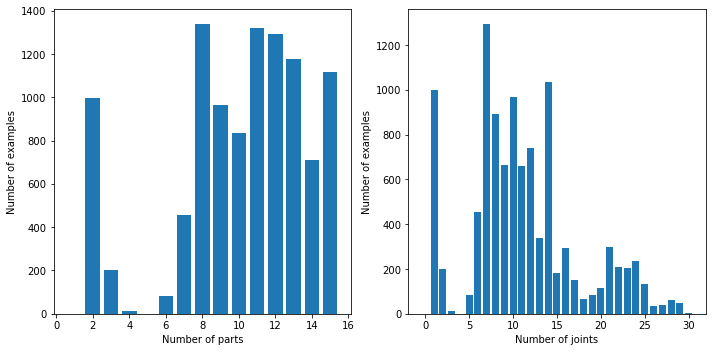

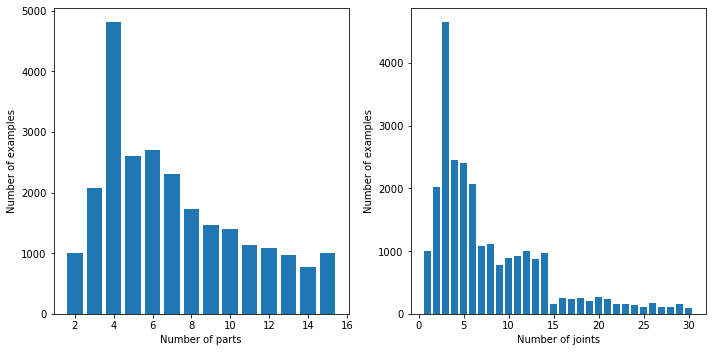

In [9]:
def plot_data(data,name):
#     gs = gridspec.GridSpec(2,2)
#     gs.update(wspace=0.5)
    
    
    plt.figure(figsize=(10,5))
    
    ax1 = plt.subplot(1, 2, 1)
    ax2 = plt.subplot(1, 2, 2)
#     ax2 = plt.subplot(gs[0, 2:])
#     ax3 = plt.subplot(gs[1, 1:3])
    
    n_parts = data['n_parts'].value_counts().to_dict()
    
    ax1.bar(n_parts.keys(),n_parts.values())
    ax1.set_ylabel('Number of examples')
    ax1.set_xlabel('Number of parts')
    
    n_joints  = data['n_joints'].value_counts().to_dict()
    ax2.bar(n_joints.keys(),n_joints.values())
    ax2.set_ylabel('Number of examples')
    ax2.set_xlabel('Number of joints')
    
#     ranges= [-1,0.25,0.5,0.75,1,1.25,1.5,1.75,10]
#     labels= [">0.25","0,25:0.5","0.5:0.75","0.75:1","1-1:25","1.25:1.5","1.5:1.75","1:75<"]
#     fit_all = []    
#     for r in range(len(ranges)-1):
#         fit_all.append(len(data.loc[data["vertpos"]>ranges[r]]))
    
#     ax3.bar(labels,fit_all)
#     ax3.set_ylabel('Number of examples')
#     ax3.set_xlabel('Range of fitness')
    
    
    plt.tight_layout()
    plt.savefig('plots/{0}.pdf'.format(name))
    plt.show()
plot_data(data_vertpos,"vertpos_dataset")
plot_data(data_velocity,"velocity_dataset")

In [36]:
all_data

,vertpos,n_parts,n_joints
0,0.642524,12,11
1,2.184245,10,14
2,2.355581,15,14
3,2.029177,8,7
4,2.532715,8,10
...,...,...,...
10499,0.882969,14,13
10500,2.019352,15,14
10501,1.004804,10,9
10502,0.288445,15,14


In [37]:
all_data.describe(include = 'all')

,vertpos,n_parts,n_joints
count,10504.000000,10504.000000,10504.000000
mean,1.268434,10.096820,11.068926
std,0.821135,3.679957,6.260979
min,-0.010000,1.000000,0.000000
25%,0.485066,8.000000,7.000000
50%,1.353009,11.000000,10.000000
75%,2.070922,13.000000,14.000000
max,2.724392,15.000000,30.000000


In [24]:
n_parts = all_data['n_parts'].value_counts().to_dict()

/home/adam/anaconda/envs/thesis-env/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  


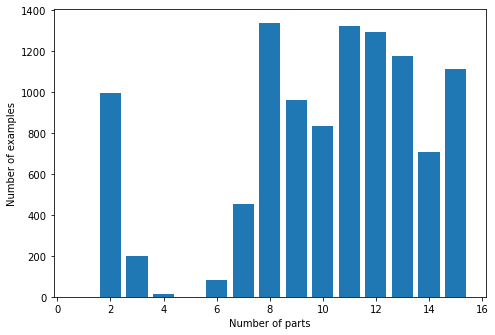

In [25]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(n_parts.keys(),n_parts.values())
ax.set_ylabel('Number of examples')
ax.set_xlabel('Number of parts')
plt.tight_layout()
plt.savefig("npartsData_all.pdf", bbox_inches = "tight")
plt.show()


In [26]:
n_joints  = all_data['n_joints'].value_counts().to_dict()

/home/adam/anaconda/envs/thesis-env/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  


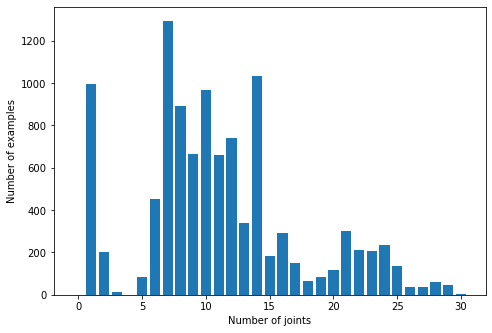

In [27]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(n_joints.keys(),n_joints.values())
ax.set_ylabel('Number of examples')
ax.set_xlabel('Number of joints')
plt.tight_layout()
plt.savefig("njointsData_all.pdf", bbox_inches = "tight")
plt.show()


In [56]:
# end = False
# c = 0
# while not end:
#     x,a = next(loader_train)
#     d =[(tf.convert_to_tensor(x)), tf.convert_to_tensor(a)]
#     x,a= d
#     gen_list = gen_f0_from_tensors(x,a)
#     ev= lossManager.framsLib.evaluate(gen_list)
#     l = len(ev)
#     for j in range(l):
#         try:
#             fit =  ev[j]['evaluations']['']['vertpos']
#         except:
#             print(ev[j])
#             print(gen_list[j])
# #     if "False" in ev:
# #         ind = ev.index("False")
# #         print(gen_list[ind])
# #         end = True
#     c +=1
#     if c >1000:
#         end = True

In [57]:
# end = False
# c = 0
# while not end:
#     x,a = next(loader_test)
#     d =[(tf.convert_to_tensor(x)), tf.convert_to_tensor(a)]
#     x,a= d
#     gen_list = gen_f0_from_tensors(x,a)
#     ev= lossManager.framsLib.evaluate(gen_list)
#     l = len(ev)
#     for j in range(l):
#         try:
#             fit =  ev[j]['evaluations']['']['vertpos']
#         except:
#             print(ev[j])
#             print(gen_list[j])
# #     if "False" in ev:
# #         ind = ev.index("False")
# #         print(gen_list[ind])
# #         end = True
#     c +=1
#     if c >500:
#         end = True

In [ ]:
c = self.framsLib.evaluate(gen_list)
for g in gen_list:
    print(g)
fit_list = [f['evaluations'][''][self.fitness] for f in c]
dist_list = self.get_latent_dist(latent_space)
rho, p = spearmanr(fit_list, dist_list)